<a href="https://colab.research.google.com/github/Dan-Burns/Seq2Ensemble/blob/main/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set working environment
!pip install -q condacolab
import condacolab
condacolab.install()

import warnings
warnings.filterwarnings("ignore")

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


In [2]:
#@title Run this cell to install required software (OpenMM, OpenAWSEM, Stride, BLAST ...)
%%capture
%%shell
#1. Install OpenMM and core dependencies
conda install -c conda-forge openmm pdbfixer mdtraj biopython nglview numpy pandas matplotlib

#2. Download openawsem
git clone https://github.com/PotoyanGroup/openawsem

#3. Download pdb_seqres
wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
mv pdb_seqres.txt openawsem/

#4. Download and isntall stride
wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz
mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc
cd stride_loc && make


#5. Download and isntall BLAST (needed only for multi-fragment simulations)
#wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.13.0+-src.tar.gz
#mkdir blast_loc && tar  -xf ncbi-blast-2.13.0+-src.tar.gz
#cd ncbi-blast-2.13.0+-src.tar.gz && ./configure
#cd ncbi-blast-2.13.0+-src.tar.gz && make


### Create Project and Run simulation

Upload a PDB file of protein which can be obtained either via AlphaFold or from PDB database. 

In [1]:
#@title Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

# Create project 

Saving 1zip_protein_only.pdb to 1zip_protein_only.pdb
User uploaded file "1zip_protein_only.pdb" with length 136729 bytes


In [2]:
#@title Run a constant temperature Molecular Dynamics with the [AWSEM](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008308) coarse-grained force-field for proteins 
Temperature = 250.0 #@param {type:"number"}
Timesteps   = 10000 #@param {type:"number"}

!export OPENAWSEM_LOCATION=/content/openawsem/ && PATH={$PATH}:/content/stride_loc && python3 /content/openawsem/mm_create_project.py input.pdb
!cp input-openmmawsem.pdb template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 ./openawsem/helperFunctions/convertOpenmmTrajectoryToStandardMovie.py template.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py

#@markdown ---
#@markdown > Lu, Wei, et al. "OpenAWSEM with Open3SPN2: A fast, flexible, and accessible framework for large-scale coarse-grained biomolecular simulations." <em>PLoS computational biology 17.2 (2021): e1008308 </em>

input
[<Chain 0>]
Chains: A
Chains info read from crystal_structure.pdb, chains to simulate:  A
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3389
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3389
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3389
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3389
  warnings.warn(
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3389
  warnings.warn(
protein: input, length: 217
/usr/local/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecogn

## Visualize the data

In [3]:
#@markdown ## Install analysis tools
%%capture
!pip install MDAnalysis
!pip install paramagpy

In [ ]:
#@markdown ## Load libraries for analysis and visualization

#@markdown #### May need to close the pop up window and re-run the cell for animation to work

import mdtraj as md
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA
import plotly.express as px


from google.colab import output
output.enable_custom_widget_manager()

def viz_q_e(file='info.dat'):

  data = pd.read_csv(file, sep='\s+')

  fig, ax = plt.subplots(ncols=3)

  ax[2].plot(data['Steps'], data['Rg'])
  ax[2].set_ylabel('Rg')
  ax[2].set_xlabel('Time Steps')

  ax[1].plot(data['Steps'], data['Q'])
  ax[1].set_ylabel('Fraction of native contacts')
  ax[1].set_xlabel('Time Steps')

  ax[0].plot(data['Steps'], data['Total'], color='red')
  ax[0].set_ylabel('Energy, kj/mol')
  ax[0].set_xlabel('Time Steps')
  fig.tight_layout()


def viz_traj(file='movie.dcd', topo='input-openmmawsem.pdb'):

  traj = md.load(file, top=topo)
  view = nv.show_mdtraj(traj)
  return view


def get_pca(data, n_pcs=10):

    pca  = PCA(n_components=n_pcs)

    proj = pca.fit_transform(data)

    ll = pca.explained_variance_

    V = pca.components_
    
    return ll, V, proj


def eig_map(V, ctmap, k=0):
    '''Reshape eigenvector V into contact map of shape ctmap
    ---
    k: eigenvector index
    V: eigenvectors
    ctmap: contact map
    ---
    returns: eigenvector map
    '''
  
    return V[k,:].reshape(ctmap.shape)



viz_traj()

NGLWidget(max_frame=194)

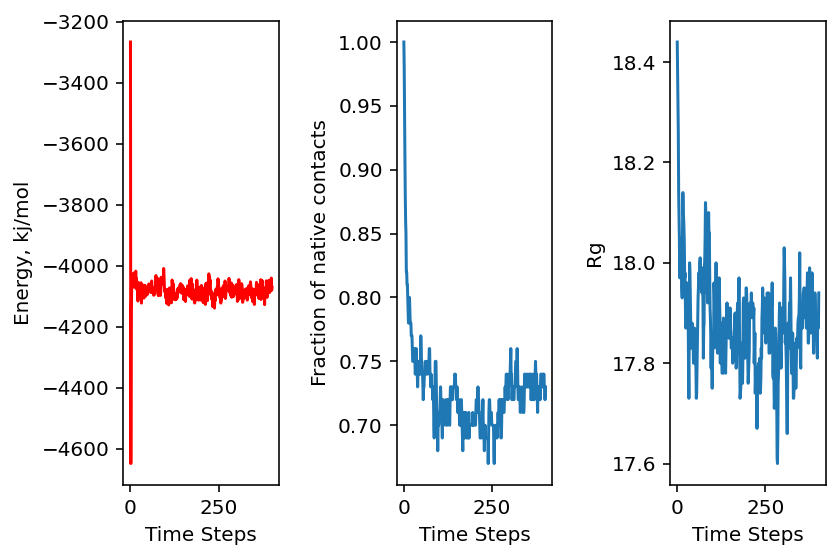

In [ ]:
#@markdown Plot timeseries of observables of interest.
%config InlineBackend.figure_format = 'retina'
viz_q_e()

In [ ]:
#@markdown ## Perform RMSD clustering
from Bio.PDB import PDBParser
import MDAnalysis.analysis.encore as encore
import MDAnalysis as mda

#@markdown Choose number of clusters to generate
n_clusters = 10 #@param {type:"number"}

pdb   = 'template.pdb'
model = PDBParser().get_structure('structure',pdb)

# hold chain IDs and residue object lists
# use to compare the subunits and figure out if they're identical or not
chains = {}
for chain in model.get_chains():
  chains[chain.id] = chain.get_unpacked_list()

trajectory = 'movie.dcd'
structure = 'template.pdb'
u = mda.Universe(structure, trajectory)

#############################

# make a dictionary of chain/subunit keys with atom selection values
selections = {}
for chain in chains.keys():
  selections[chain] = u.select_atoms('segid '+chain)

# make a directory to hold the seperated subunits
out_dir = 'seperated_trajectories/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# clean the directory if it already exists
for f in os.listdir(out_dir):
    os.remove(out_dir+f)

# Instead of writing the seperated trajectories to files, 
# can probably use u.merge()
for chain, selection in selections.items():
    with mda.Writer(out_dir+'chain_'+chain+'.dcd', selection.n_atoms) as W:
        for ts in u.trajectory:
            W.write(selection)
# write one subunit to a pdb
# can probably just use the selection instead of a saved pdb
# assuming we're just working with EI dimer for this
selections[list(selections.keys())[0]].write('one_subunit.pdb')

# align
from MDAnalysis.analysis import align
seperated_trajs = [out_dir+traj for traj in os.listdir(out_dir) if traj.endswith('dcd')]
new_pdb = 'one_subunit.pdb'
ref = mda.Universe(new_pdb)
sep_u = mda.Universe(new_pdb, seperated_trajs)
align.AlignTraj(sep_u, ref,select='name CA',filename='aligned_seperated_subunits.dcd').run()

for cluster_iteration in range(n_clusters):
    structure = 'one_subunit.pdb'
    trajectory = 'aligned_seperated_subunits.dcd'
    u = mda.Universe(structure, trajectory)
    # add n_jobs argument so that all n_init are run in parallel (default is 10)
    ensemble = encore.cluster(u, method=encore.clustering.ClusteringMethod.KMeans(n_clusters=cluster_iteration+1))
    #####################################
    # change this selection from 'name CA' to 'protein' when using structure file with 
    # correct residue names
    #####################################
    selection = u.select_atoms('protein')
    ######################################
    clusters = []
    for i, cluster in enumerate(ensemble.clusters):
        u.trajectory[cluster.centroid]
        if not os.path.exists(f'cluster_{cluster_iteration+1}/'):
          os.makedirs(f'cluster_{cluster_iteration+1}/')
        selection.write(f'cluster_{cluster_iteration+1}/centroid_{i+1}.pdb')
        clusters.append(int(cluster.centroid))

In [ ]:
#@title Package and download clustering results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `Clustering_output.zip`, right-click and select \"Download\".

%%capture
!zip -FSr "Clustering_output.zip" cluster_*
files.download("Clustering_output.zip")

  adding: cluster_1/ (stored 0%)
  adding: cluster_1/centroid_1.pdb (deflated 77%)
  adding: cluster_10/ (stored 0%)
  adding: cluster_10/centroid_3.pdb (deflated 77%)
  adding: cluster_10/centroid_5.pdb (deflated 77%)
  adding: cluster_10/centroid_8.pdb (deflated 77%)
  adding: cluster_10/centroid_9.pdb (deflated 77%)
  adding: cluster_10/centroid_1.pdb (deflated 77%)
  adding: cluster_10/centroid_10.pdb (deflated 77%)
  adding: cluster_10/centroid_6.pdb (deflated 77%)
  adding: cluster_10/centroid_2.pdb (deflated 77%)
  adding: cluster_10/centroid_4.pdb (deflated 77%)
  adding: cluster_10/centroid_7.pdb (deflated 77%)
  adding: cluster_2/ (stored 0%)
  adding: cluster_2/centroid_1.pdb (deflated 77%)
  adding: cluster_2/centroid_2.pdb (deflated 77%)
  adding: cluster_3/ (stored 0%)
  adding: cluster_3/centroid_3.pdb (deflated 77%)
  adding: cluster_3/centroid_1.pdb (deflated 77%)
  adding: cluster_3/centroid_2.pdb (deflated 77%)
  adding: cluster_4/ (stored 0%)
  adding: cluster_4/cen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Perform PCA on cartesian positions of protein backbone

traj = md.load('movie.dcd', top='input-openmmawsem.pdb')

traju =  traj.superpose(reference=traj)

sel_ca   = traju.topology.select('name CA')

pos = traju.xyz[:, sel_ca, :] #time, atoms, 3
pos_data = pos.reshape(traju.n_frames, -1)

ll, V, proj = get_pca(pos_data)

#print('Origina data shape', 'Reduced data shape')
df = pd.DataFrame(proj, columns=[f'PC{i+1}' for i in range(10)])
df['Steps'] = df.index

fig = px.scatter_matrix(df,
        dimensions=["PC1", "PC2", "PC3"],
        color="Steps" 
        )
  
fig.update_traces(diagonal_visible=False)
fig.show()